Analysis of results from full CV from Claude Sonnet and Open AI GPT

c:\Users\gabyf\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


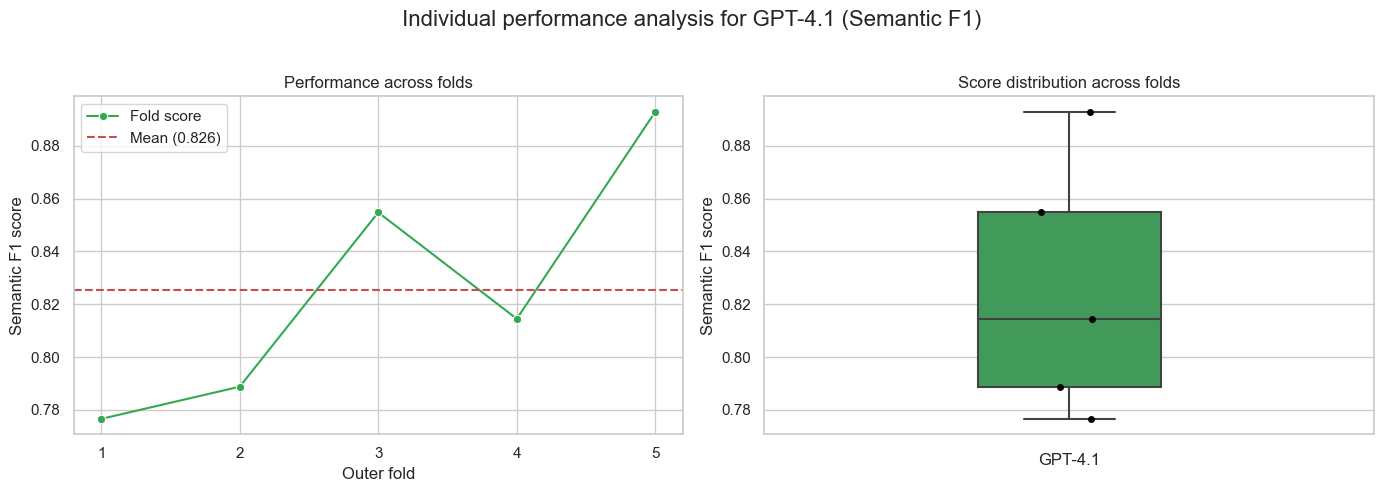

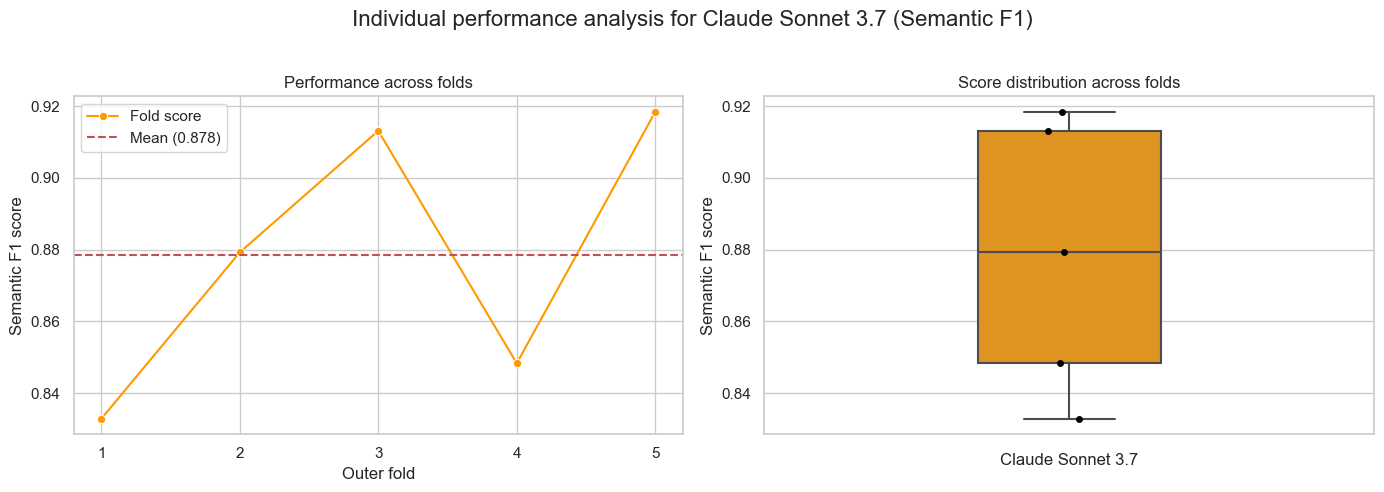

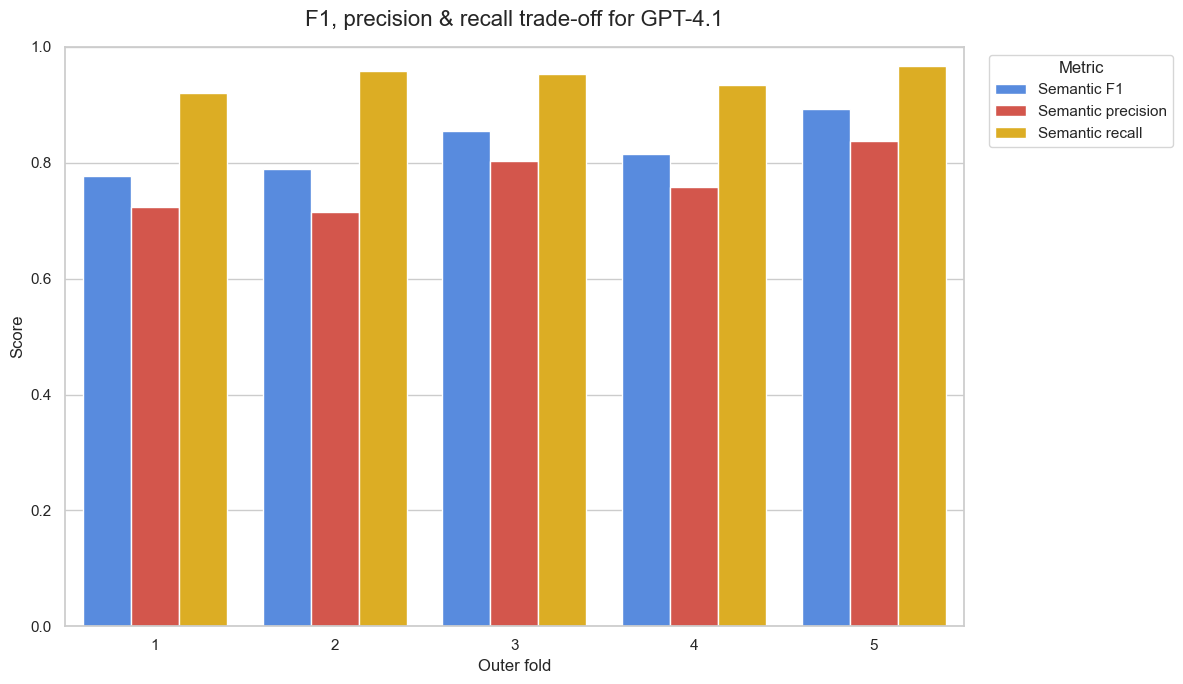

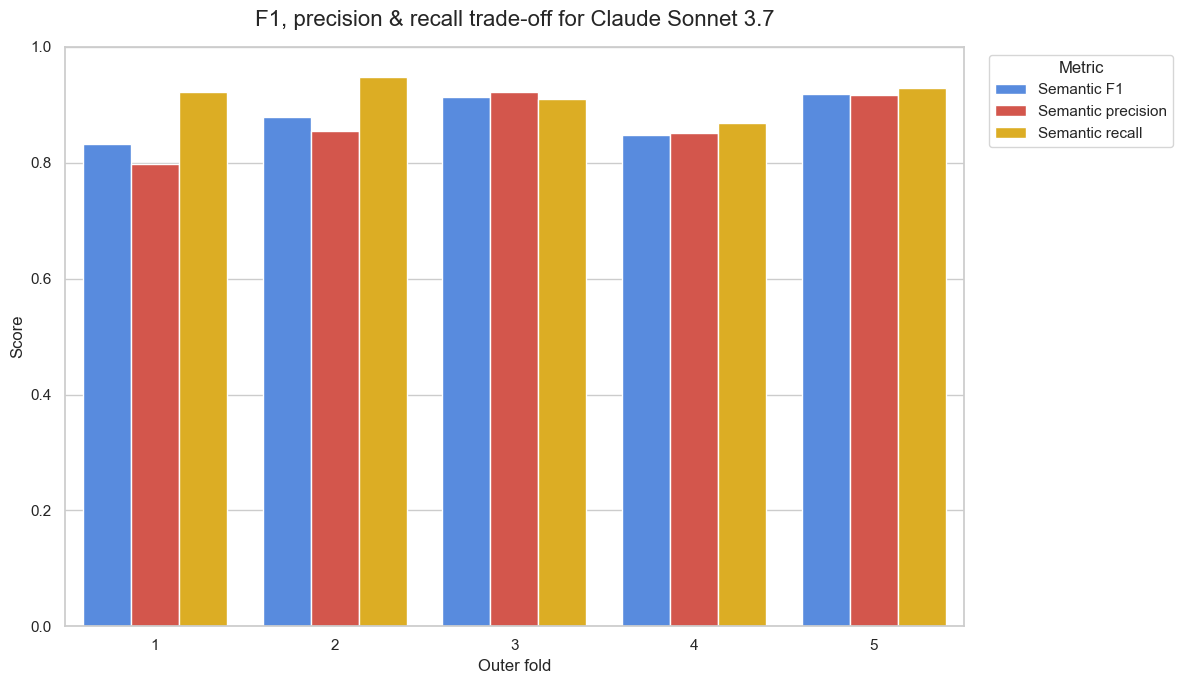

Statistical significance testing for Semantic F1

a) Normality check of differences:
   Shapiro-Wilk test p-value: 0.6593
   Interpretation: Low power with N=5 justifies using a non-parametric test regardless of p-value.



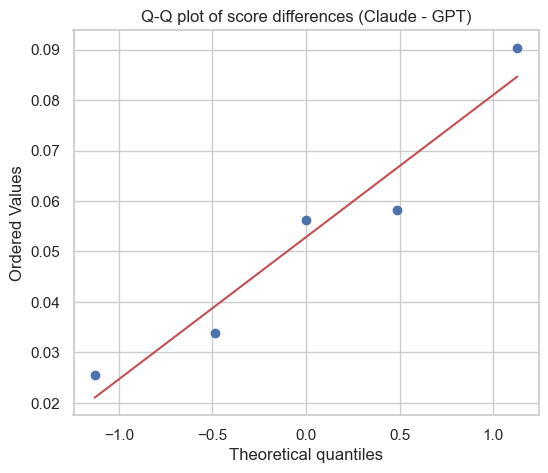

d) Paired Student t-test:
   t-statistic: 4.6688
   P-value: 0.0095
   Conclusion: The mean Semantic F1 is significantly different between models.

b) Wilcoxon signed-rank test:
   P-value: 0.0625
   Conclusion: The difference is not statistically significant (p >= 0.05).

c) Bootstrap confidence interval for the mean difference:
   Mean difference (Claude - GPT): 0.0528
   95% Bootstrap CI: [0.0337, 0.0722]
   Interpretation: The entire interval is above zero, providing strong evidence that Claude is superior.



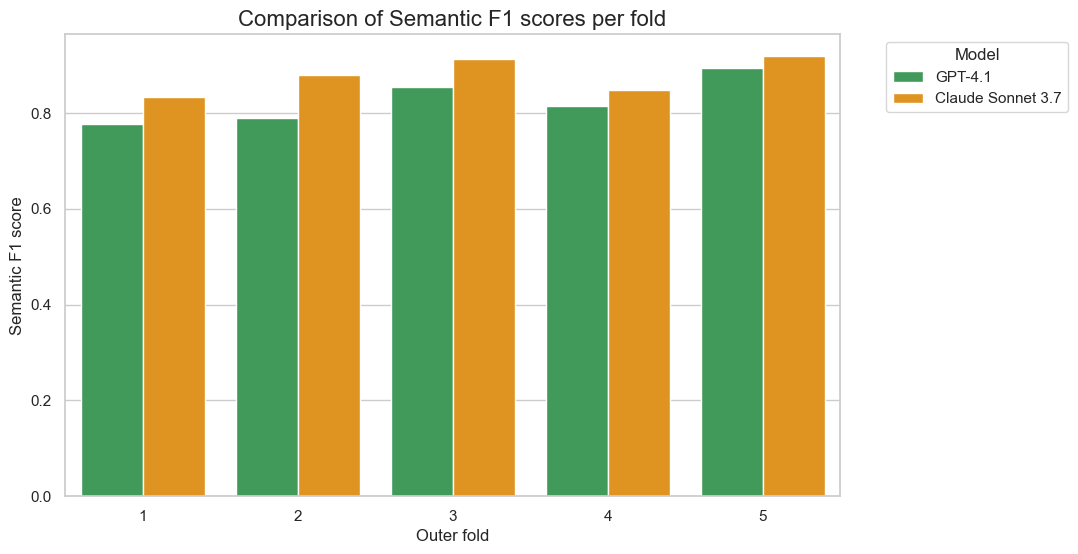

c) The executive summary plot (mean performance):


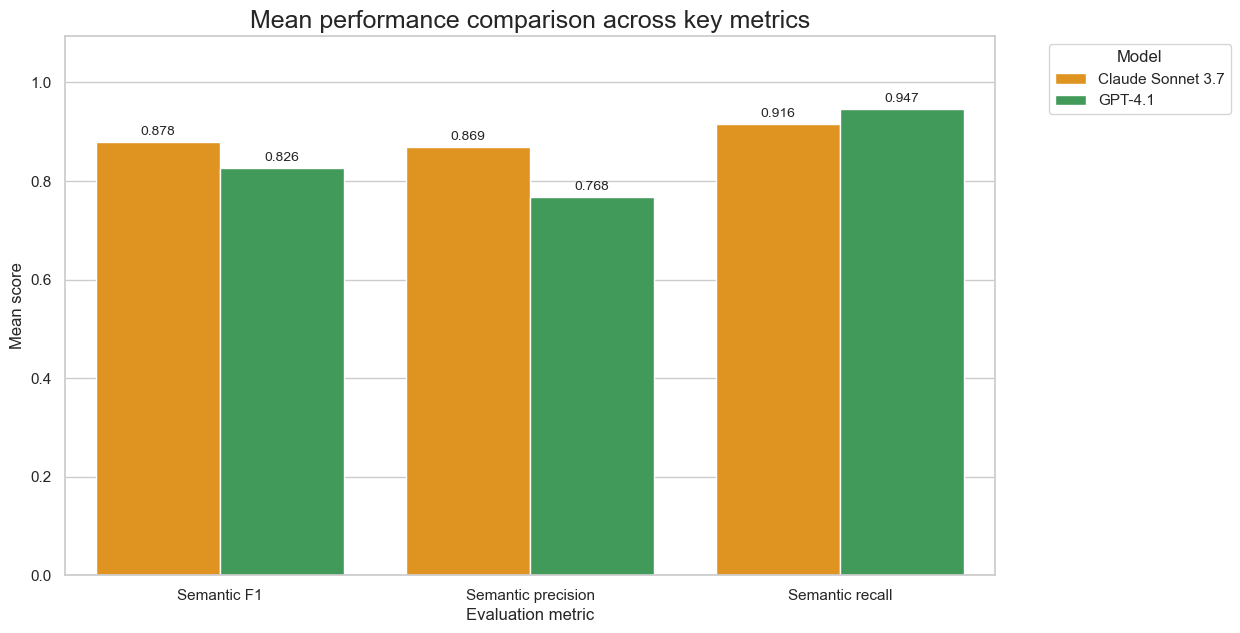

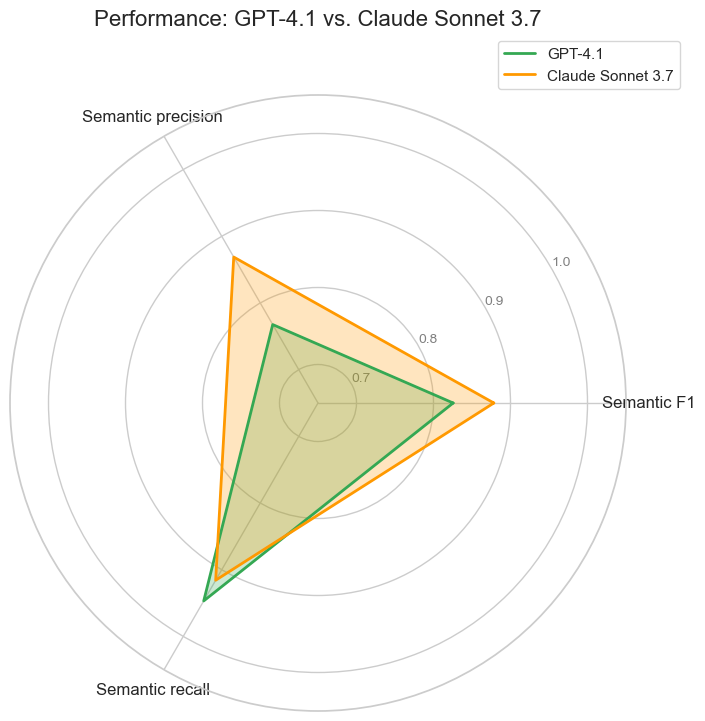

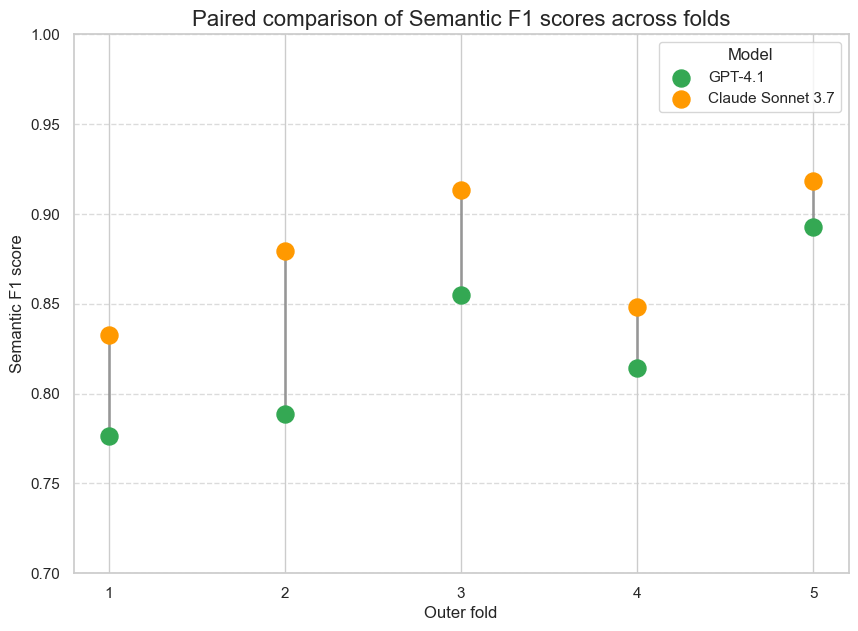

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

data = {
    'fold': [1, 2, 3, 4, 5],
    'gpt_semF1': [0.7766, 0.7888, 0.8548, 0.8145, 0.8929],
    'claude_semF1': [0.8328, 0.8792, 0.9131, 0.8483, 0.9184],
    'gpt_semPrec': [0.7240, 0.7147, 0.8033, 0.7581, 0.8379],
    'claude_semPrec': [0.7984, 0.8550, 0.9227, 0.8513, 0.9169],
    'gpt_semRec': [0.9201, 0.9592, 0.9533, 0.9350, 0.9665],
    'claude_semRec': [0.9223, 0.9480, 0.9106, 0.8693, 0.9288]
}

df = pd.DataFrame(data)

models = ['gpt', 'claude']
model_names = {'gpt': 'GPT-4.1', 'claude': 'Claude Sonnet 3.7'}
model_color_palette = {'gpt': '#34A853', 'claude': '#FF9900'} # Green for GPT, Orange for Claude
model_color_palette_full_names = {
    'GPT-4.1': '#34A853', 
    'Claude Sonnet 3.7': '#FF9900'
}
metric_color_palette = {
    'Semantic F1': '#4285F4',      
    'Semantic precision': '#EA4335',
    'Semantic recall': '#FBBC05'  
}
metric_names_map = {
    'semF1': 'Semantic F1',
    'semPrec': 'Semantic precision',
    'semRec': 'Semantic recall'
}

sns.set_theme(style="whitegrid")


# Descriptive statistics for each model
for model_code in models:
    model_name = model_names[model_code]
    mean_score = df[f'{model_code}_semF1'].mean()
    std_score = df[f'{model_code}_semF1'].std()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Individual performance analysis for {model_name} (Semantic F1)', fontsize=16)

    sns.lineplot(x='fold', y=f'{model_code}_semF1', data=df, marker='o', color=model_color_palette[model_code], ax=axes[0], label='Fold score')
    axes[0].axhline(y=mean_score, color='r', linestyle='--', label=f'Mean ({mean_score:.3f})')
    axes[0].set_title('Performance across folds')
    axes[0].set_xlabel('Outer fold')
    axes[0].set_ylabel('Semantic F1 score')
    axes[0].set_xticks(df['fold'])
    axes[0].legend()
    axes[0].grid(True)

    sns.boxplot(y=f'{model_code}_semF1', data=df, color=model_color_palette[model_code], ax=axes[1], width=0.3)
    sns.stripplot(y=f'{model_code}_semF1', data=df, color='black', ax=axes[1], jitter=0.05)
    axes[1].set_title('Score distribution across folds')
    axes[1].set_ylabel('Semantic F1 score')
    axes[1].set_xlabel(model_name)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

df_long = df.melt(id_vars=['fold'], 
                  value_vars=[f'{m}_{met}' for m in models for met in metric_names_map.keys()],
                  var_name='metric_model', value_name='score')
df_long[['model', 'metric']] = df_long['metric_model'].str.split('_', expand=True)
df_long['metric'] = df_long['metric'].map(metric_names_map)

for model_code, model_name in model_names.items():
    plt.figure(figsize=(12, 7))
    plot_data = df_long[df_long['model'] == model_code]
    ax = sns.barplot(x='fold', y='score', hue='metric', data=plot_data, palette=metric_color_palette)
    ax.set_title(f'F1, precision & recall trade-off for {model_name}', fontsize=16, pad=15)
    ax.set_xlabel('Outer fold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(bottom=0, top=1.0)
    plt.tight_layout()
    plt.show()


print("Statistical significance testing for Semantic F1\n")

# Calculate differences for tests
df['semF1_diff'] = df['claude_semF1'] - df['gpt_semF1']
differences = df['semF1_diff'].values

# Normality Check
print("a) Normality check of differences:")
shapiro_stat, shapiro_p = stats.shapiro(differences)
print(f"   Shapiro-Wilk test p-value: {shapiro_p:.4f}")
print("   Interpretation: Low power with N=5 justifies using a non-parametric test regardless of p-value.\n")
plt.figure(figsize=(6, 5))
stats.probplot(differences, dist="norm", plot=plt)
plt.title("Q-Q plot of score differences (Claude - GPT)")
plt.show()

# Paired Student t-test 
print("d) Paired Student t-test:")
ttest_stat, ttest_p = stats.ttest_rel(df['claude_semF1'], df['gpt_semF1'])
print(f"   t-statistic: {ttest_stat:.4f}")
print(f"   P-value: {ttest_p:.4f}")
if ttest_p < 0.01:
    print("   Conclusion: The mean Semantic F1 is significantly different between models.\n")
else:
    print("   Conclusion: No significant difference in mean Semantic F1.\n")

# Wilcoxon Test
print("b) Wilcoxon signed-rank test:")
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(df['claude_semF1'], df['gpt_semF1'])
print(f"   P-value: {wilcoxon_p:.4f}")
if wilcoxon_p < 0.01:
    print("   Conclusion: The difference is statistically significant (p < 0.05).\n")
else:
    print("   Conclusion: The difference is not statistically significant (p >= 0.05).\n")

# Bootstrap CI
print("c) Bootstrap confidence interval for the mean difference:")
n_bootstrap_samples = 10000
bootstrap_means = np.array([np.mean(np.random.choice(differences, size=len(differences), replace=True)) for _ in range(n_bootstrap_samples)])
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)
print(f"   Mean difference (Claude - GPT): {np.mean(differences):.4f}")
print(f"   95% Bootstrap CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0 and ci_upper > 0:
    print("   Interpretation: The entire interval is above zero, providing strong evidence that Claude is superior.\n")
else:
    print("   Interpretation: The interval crosses zero, so we cannot be confident of a consistent advantage.\n")



# Grouped Bar Chart 
plot_data = df_long[df_long['metric'] == 'Semantic F1'].copy()
plot_data['model'] = plot_data['model'].map(model_names)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='fold', y='score', hue='model', data=plot_data, palette=model_color_palette_full_names) 
ax.set_title(f'Comparison of Semantic F1 scores per fold', fontsize=16)
ax.set_ylabel('Semantic F1 score')
ax.set_xlabel('Outer fold')
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("c) The executive summary plot (mean performance):")
df_means = df_long.groupby(['model', 'metric'])['score'].mean().reset_index()
df_means['model'] = df_means['model'].map(model_names)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='metric', y='score', hue='model', data=df_means, palette=model_color_palette_full_names)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10, padding=3)
ax.set_title('Mean performance comparison across key metrics', fontsize=18)
ax.set_xlabel('Evaluation metric')
ax.set_ylabel('Mean score')
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




from math import pi

# Radar chart
df_means = df_long.groupby(['model', 'metric'])['score'].mean().reset_index()
df_radar = df_means.pivot(index='model', columns='metric', values='score').reset_index()

categories = list(df_radar)[1:]
N = len(categories)

# Angle of each axis in the plot
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] # Repeat first angle to close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for model_code, model_name in model_names.items():
    color = model_color_palette[model_code]
    values = df_radar[df_radar['model']==model_code].drop('model', axis=1).values.flatten().tolist()
    values += values[:1] # Repeat first value to close the circle
    
    # area
    ax.fill(angles, values, color=color, alpha=0.25)
    # outline
    ax.plot(angles, values, color=color, linewidth=2, label=model_name)

#labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)

# radial axis labels
ax.set_rlabel_position(30)
plt.yticks([0.7, 0.8, 0.9, 1.0], ["0.7", "0.8", "0.9", "1.0"], color="grey", size=10)
plt.ylim(0.65, 1.05)

plt.title('Performance: GPT-4.1 vs. Claude Sonnet 3.7', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()





#Dumbbell plot
dumbbell_df = pd.DataFrame({
    'fold': df['fold'],
    'gpt': df['gpt_semF1'],
    'claude': df['claude_semF1']
})

plt.figure(figsize=(10, 7))

plt.vlines(x=dumbbell_df['fold'], ymin=dumbbell_df['gpt'], ymax=dumbbell_df['claude'], 
           color='grey', alpha=0.7, linewidth=2, label='_nolegend_') #

plt.scatter(dumbbell_df['fold'], dumbbell_df['gpt'], color=model_color_palette['gpt'], s=150, zorder=3, label='GPT-4.1')
plt.scatter(dumbbell_df['fold'], dumbbell_df['claude'], color=model_color_palette['claude'], s=150, zorder=3, label='Claude Sonnet 3.7')

plt.title('Paired comparison of Semantic F1 scores across folds', fontsize=16)
plt.ylabel('Semantic F1 score', fontsize=12) 
plt.xlabel('Outer fold', fontsize=12)     
plt.xticks(dumbbell_df['fold'])            
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.ylim(bottom=0.7, top=1.0) 

plt.show()



Comparison rule based vs extracted based, using both the Claude 3.7 Sonnet as the LLM

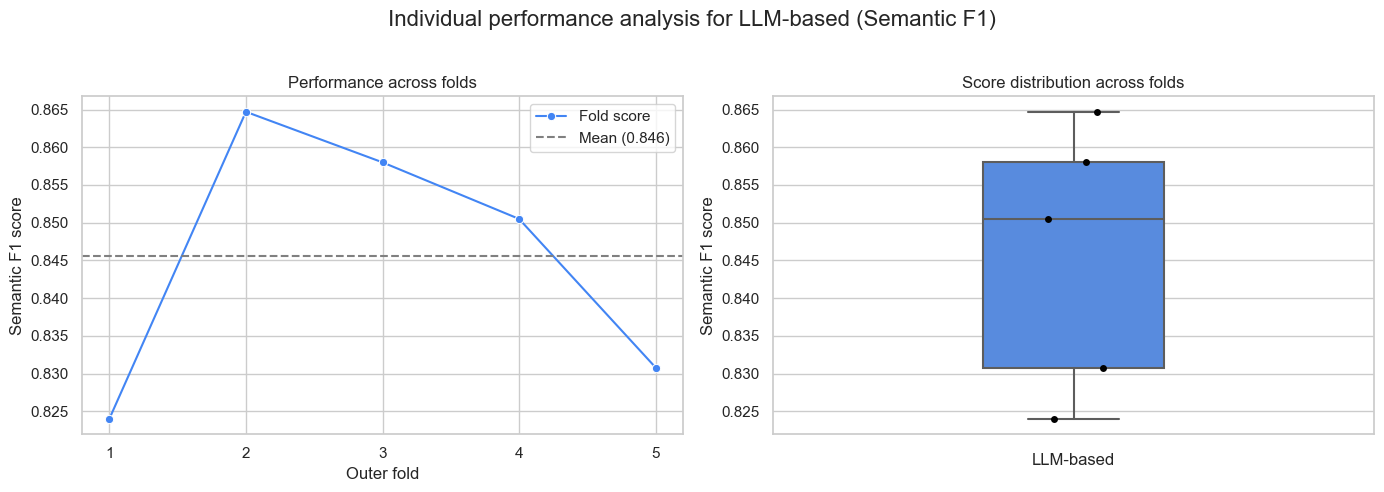

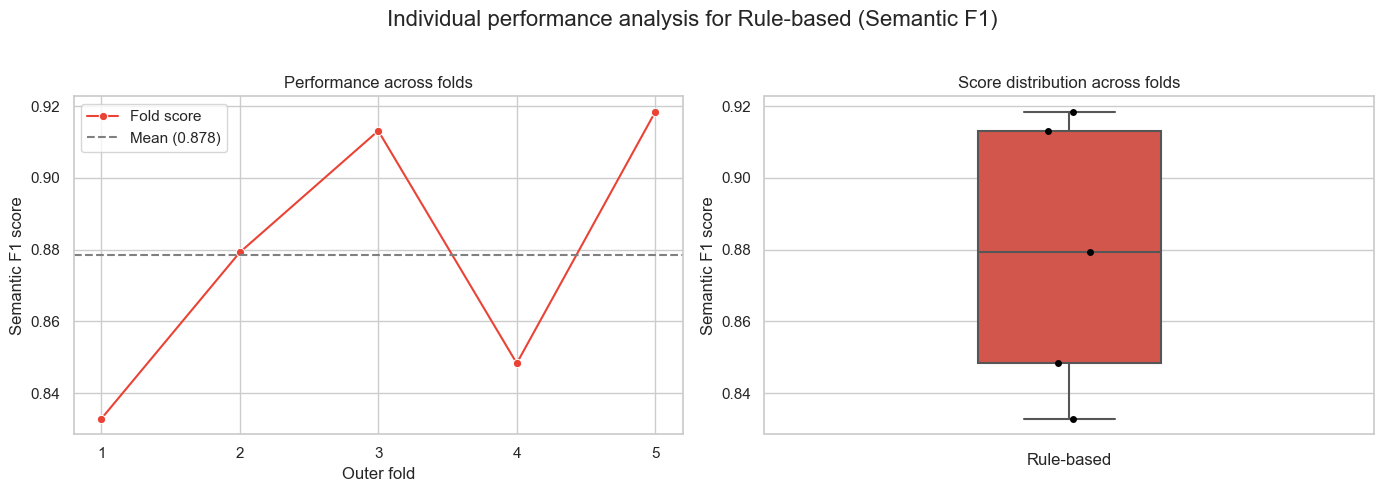

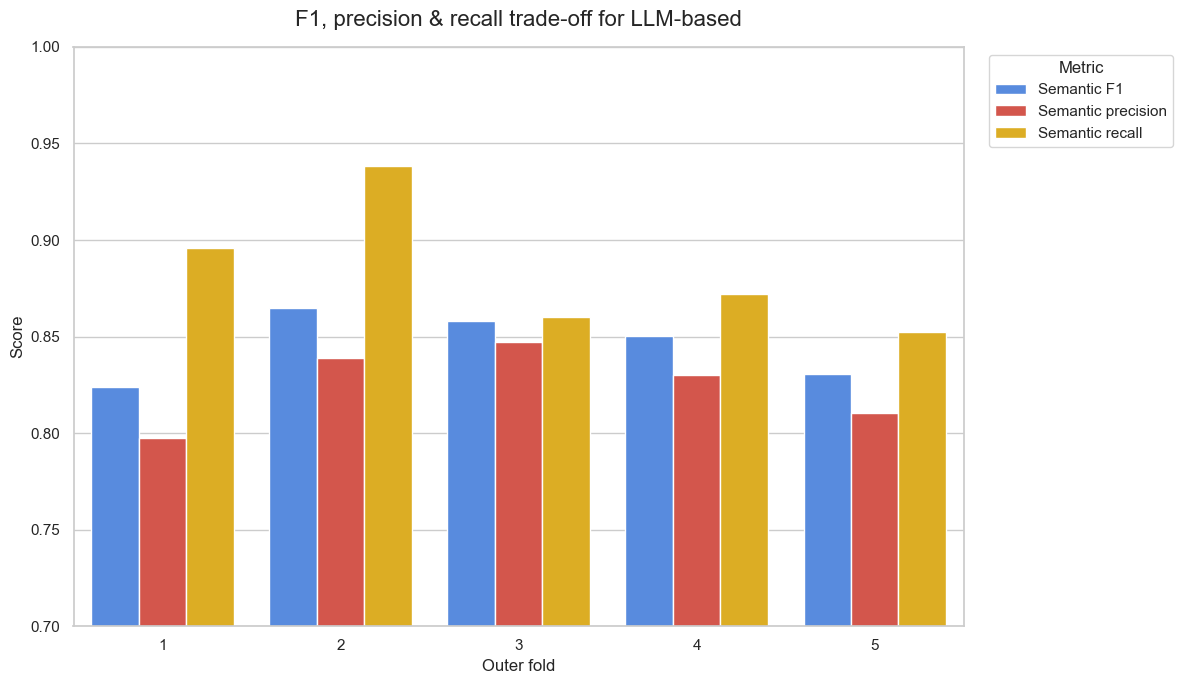

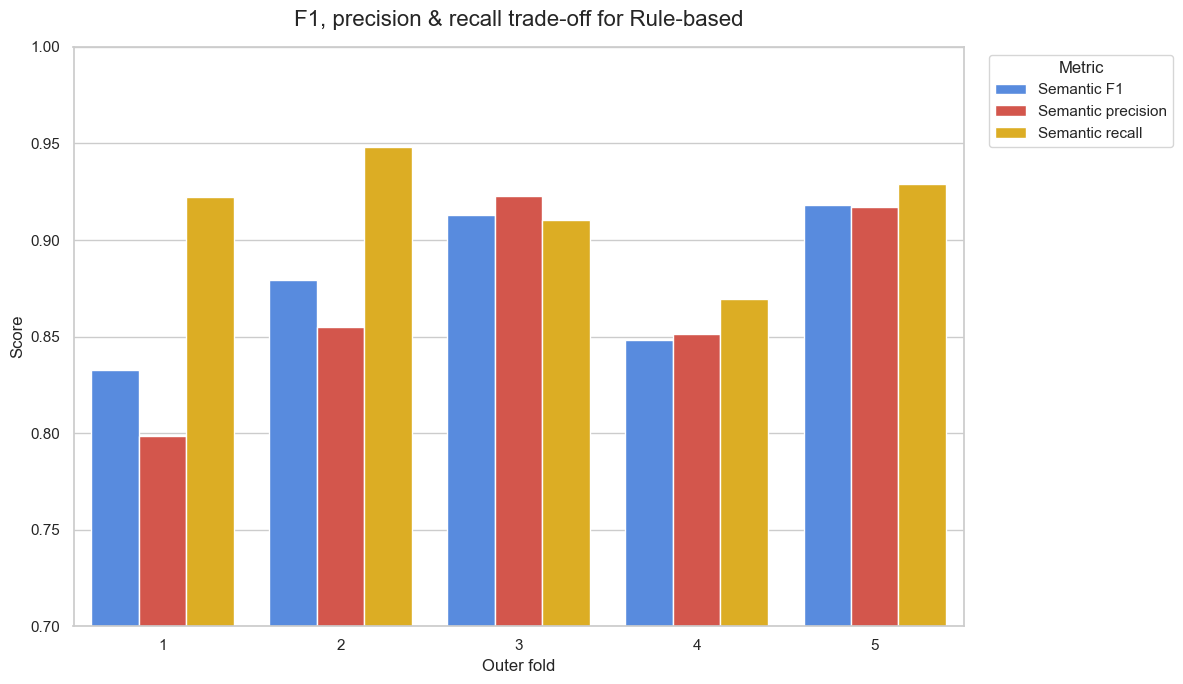

Statistical significance testing for Semantic F1 (LLM-based vs. Rule-based)

a) Normality check of differences:
   Shapiro-Wilk test p-value: 0.3614
   Interpretation: Low power with N=5 justifies using a non-parametric test regardless of p-value.



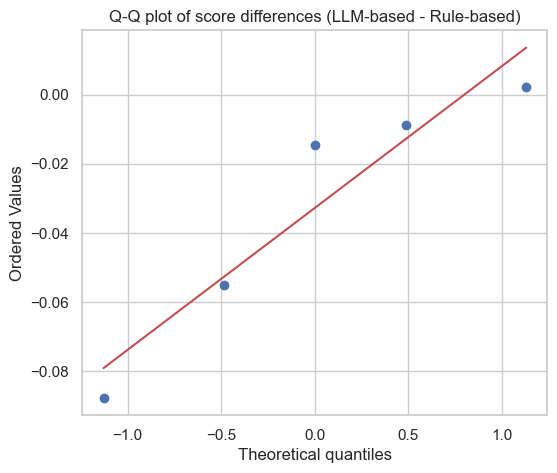

b) Wilcoxon signed-rank test:
   P-value: 0.1250
   Conclusion: The difference is not statistically significant (p >= 0.05).

c) Bootstrap confidence interval for the mean difference:
   Mean difference (LLM-based - Rule-based): -0.0328
   95% Bootstrap CI: [-0.0631, -0.0055]
   Interpretation: The entire interval is below zero, providing evidence that Rule-based is superior.

d) Paired Student t-test:
   t-statistic: -1.9515
   P-value: 0.1227
   Conclusion: No significant difference in mean Semantic F1.



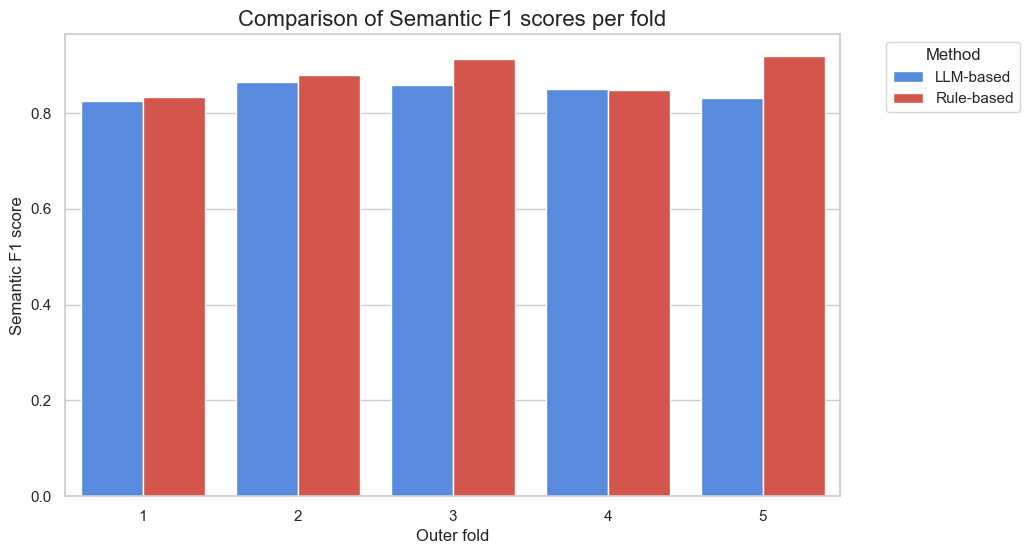

Executive summary plot (mean performance):


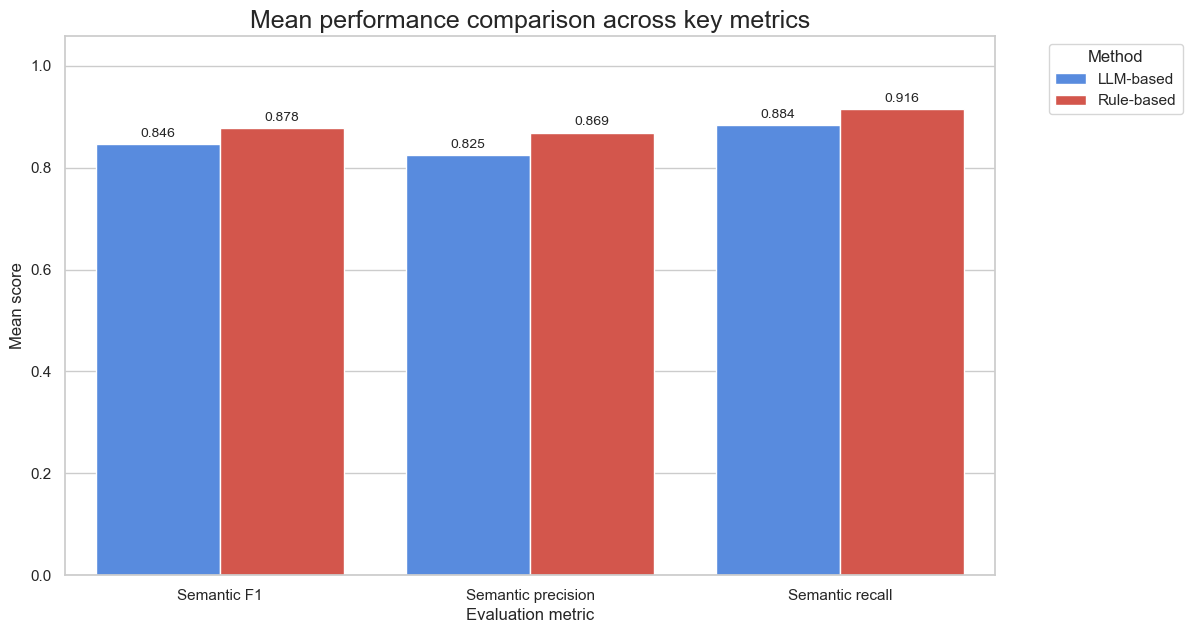

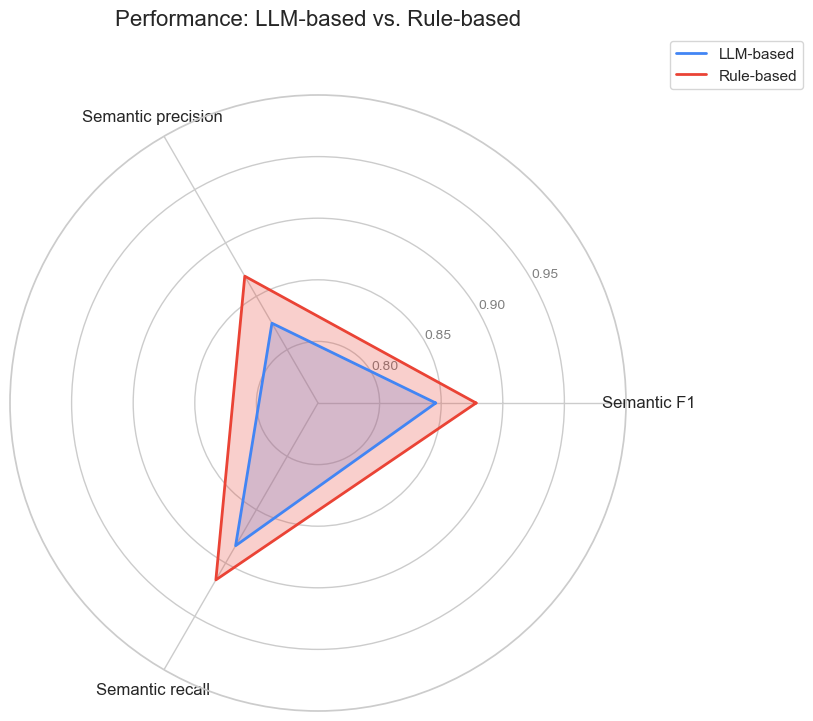

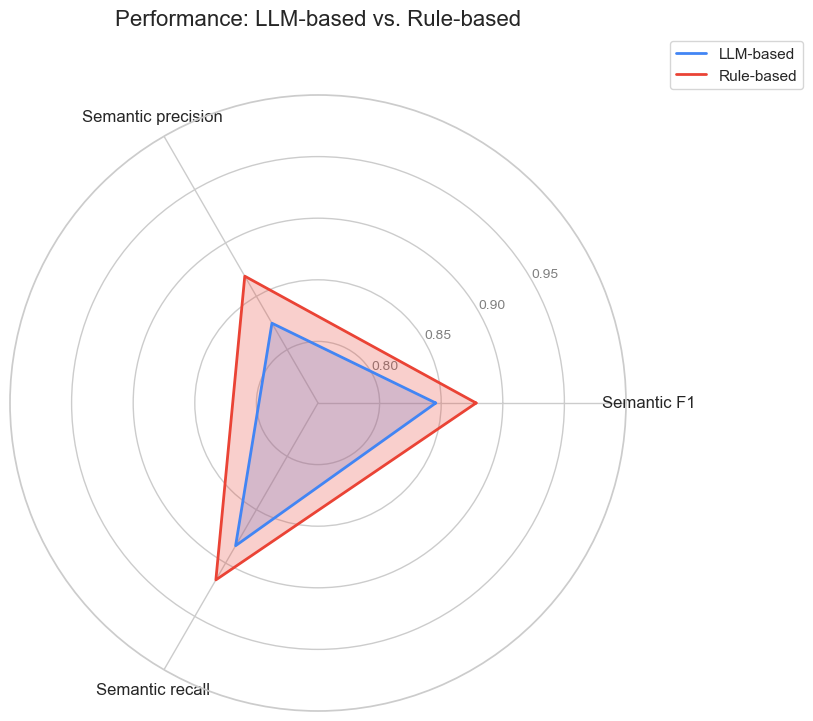

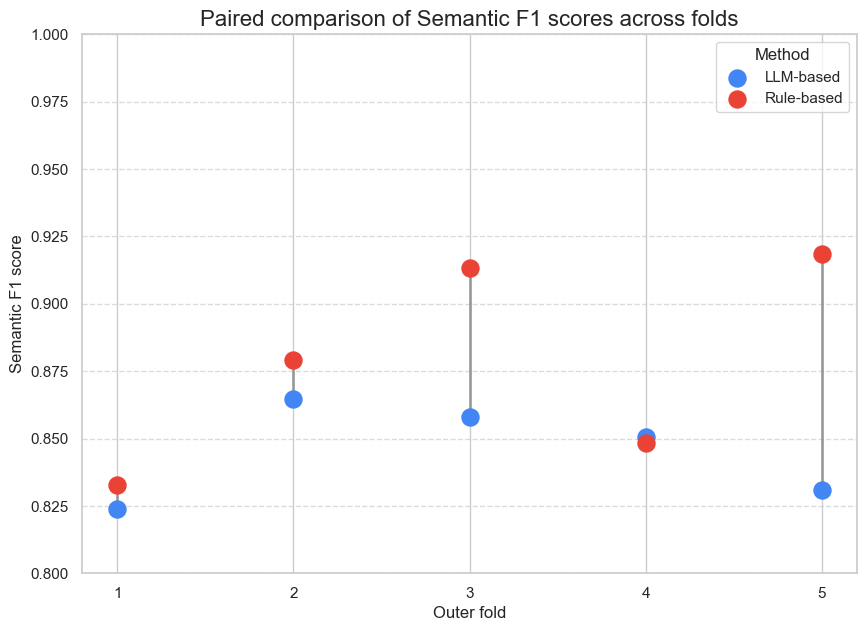

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

data = {
    'fold': [1, 2, 3, 4, 5],
    # Rule-based Data
    'rule_semF1': [0.8328, 0.8792, 0.9131, 0.8483, 0.9184],
    'rule_semPrec': [0.7984, 0.8550, 0.9227, 0.8513, 0.9169],
    'rule_semRec': [0.9223, 0.9480, 0.9106, 0.8693, 0.9288],
    # LLM-based Data
    'llm_semF1': [0.8240, 0.8647, 0.8580, 0.8505, 0.8308],
    'llm_semPrec': [0.7977, 0.8389, 0.8470, 0.8301, 0.8102],
    'llm_semRec': [0.8958, 0.9385, 0.8600, 0.8720, 0.8525]
}

df = pd.DataFrame(data)

models = ['llm', 'rule']
model_names = {'llm': 'LLM-based', 'rule': 'Rule-based'}
model_color_palette = {'llm': '#4285F4', 'rule': '#EA4335'} # Blue for LLM, Red for Rule-based
model_color_palette_full_names = {
    'LLM-based': '#4285F4', 
    'Rule-based': '#EA4335'
}
metric_color_palette = {
    'Semantic F1': '#4285F4',      
    'Semantic precision': '#EA4335',
    'Semantic recall': '#FBBC05'  
}
metric_names_map = {
    'semF1': 'Semantic F1',
    'semPrec': 'Semantic precision',
    'semRec': 'Semantic recall'
}

sns.set_theme(style="whitegrid")

for model_code in models:
    model_name = model_names[model_code]
    mean_score = df[f'{model_code}_semF1'].mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Individual performance analysis for {model_name} (Semantic F1)', fontsize=16)

    # Performance across folds
    sns.lineplot(x='fold', y=f'{model_code}_semF1', data=df, marker='o', color=model_color_palette[model_code], ax=axes[0], label='Fold score')
    axes[0].axhline(y=mean_score, color='grey', linestyle='--', label=f'Mean ({mean_score:.3f})')
    axes[0].set_title('Performance across folds')
    axes[0].set_xlabel('Outer fold')
    axes[0].set_ylabel('Semantic F1 score')
    axes[0].set_xticks(df['fold'])
    axes[0].legend()
    axes[0].grid(True)

    # Score distribution boxplot
    sns.boxplot(y=f'{model_code}_semF1', data=df, color=model_color_palette[model_code], ax=axes[1], width=0.3)
    sns.stripplot(y=f'{model_code}_semF1', data=df, color='black', ax=axes[1], jitter=0.05)
    axes[1].set_title('Score distribution across folds')
    axes[1].set_ylabel('Semantic F1 score')
    axes[1].set_xlabel(model_name)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

df_long = df.melt(id_vars=['fold'], 
                  value_vars=[f'{m}_{met}' for m in models for met in metric_names_map.keys()],
                  var_name='metric_model', value_name='score')
df_long[['model', 'metric']] = df_long['metric_model'].str.split('_', expand=True)
df_long['metric'] = df_long['metric'].map(metric_names_map)

# trade-off between Precision, Recall, and F1 for each model.
for model_code, model_name in model_names.items():
    plt.figure(figsize=(12, 7))
    plot_data = df_long[df_long['model'] == model_code]
    ax = sns.barplot(x='fold', y='score', hue='metric', data=plot_data, palette=metric_color_palette)
    ax.set_title(f'F1, precision & recall trade-off for {model_name}', fontsize=16, pad=15)
    ax.set_xlabel('Outer fold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(bottom=0.7, top=1.0)
    plt.tight_layout()
    plt.show()

print("Statistical significance testing for Semantic F1 (LLM-based vs. Rule-based)\n")

# Calculate differences for tests (LLM - Rule)
df['semF1_diff'] = df['llm_semF1'] - df['rule_semF1']
differences = df['semF1_diff'].values

# a) Normality Check
print("a) Normality check of differences:")
shapiro_stat, shapiro_p = stats.shapiro(differences)
print(f"   Shapiro-Wilk test p-value: {shapiro_p:.4f}")
print("   Interpretation: Low power with N=5 justifies using a non-parametric test regardless of p-value.\n")
plt.figure(figsize=(6, 5))
stats.probplot(differences, dist="norm", plot=plt)
plt.title("Q-Q plot of score differences (LLM-based - Rule-based)")
plt.show()

# b) Wilcoxon Test (Non-parametric paired test)
print("b) Wilcoxon signed-rank test:")
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(df['llm_semF1'], df['rule_semF1'])
print(f"   P-value: {wilcoxon_p:.4f}")
if wilcoxon_p < 0.05:
    print("   Conclusion: The difference is statistically significant (p < 0.05).\n")
else:
    print("   Conclusion: The difference is not statistically significant (p >= 0.05).\n")

# c) Bootstrap CI for mean difference
print("c) Bootstrap confidence interval for the mean difference:")
n_bootstrap_samples = 10000
bootstrap_means = np.array([np.mean(np.random.choice(differences, size=len(differences), replace=True)) for _ in range(n_bootstrap_samples)])
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)
print(f"   Mean difference (LLM-based - Rule-based): {np.mean(differences):.4f}")
print(f"   95% Bootstrap CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0 and ci_upper > 0:
    print("   Interpretation: The entire interval is above zero, providing evidence that LLM-based is superior.\n")
elif ci_lower < 0 and ci_upper < 0:
    print("   Interpretation: The entire interval is below zero, providing evidence that Rule-based is superior.\n")
else:
    print("   Interpretation: The interval crosses zero, so we cannot be confident of a consistent advantage for either method.\n")
    
# d) Paired Student t-test 
print("d) Paired Student t-test:")
ttest_stat, ttest_p = stats.ttest_rel(df['llm_semF1'], df['rule_semF1'])
print(f"   t-statistic: {ttest_stat:.4f}")
print(f"   P-value: {ttest_p:.4f}")
if ttest_p < 0.05:
    print("   Conclusion: The mean Semantic F1 is significantly different between methods.\n")
else:
    print("   Conclusion: No significant difference in mean Semantic F1.\n")


plot_data = df_long[df_long['metric'] == 'Semantic F1'].copy()
plot_data['model'] = plot_data['model'].map(model_names)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='fold', y='score', hue='model', data=plot_data, palette=model_color_palette_full_names) 
ax.set_title('Comparison of Semantic F1 scores per fold', fontsize=16)
ax.set_ylabel('Semantic F1 score')
ax.set_xlabel('Outer fold')
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("Executive summary plot (mean performance):")

df_means = df_long.groupby(['model', 'metric'])['score'].mean().reset_index()

plot_df_means = df_means.copy()

plot_df_means['model'] = plot_df_means['model'].map(model_names)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='metric', y='score', hue='model', data=plot_df_means, palette=model_color_palette_full_names)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=10, padding=3)
ax.set_title('Mean performance comparison across key metrics', fontsize=18)
ax.set_xlabel('Evaluation metric')
ax.set_ylabel('Mean score')
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Radar chart
from math import pi

df_radar = df_means.pivot(index='model', columns='metric', values='score').reset_index()

categories = list(df_radar)[1:]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for model_code, model_name in model_names.items():
    color = model_color_palette[model_code]
    values = df_radar[df_radar['model']==model_code].drop('model', axis=1).values.flatten().tolist()
    values += values[:1]
    
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.plot(angles, values, color=color, linewidth=2, label=model_name)
    
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_rlabel_position(30)
plt.yticks([0.80, 0.85, 0.90, 0.95], ["0.80", "0.85", "0.90", "0.95"], color="grey", size=10)
plt.ylim(0.75, 1.0)

plt.title('Performance: LLM-based vs. Rule-based', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

from math import pi

df_radar = df_means.pivot(index='model', columns='metric', values='score').reset_index()

categories = list(df_radar)[1:]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for model_code, model_name in model_names.items():
    color = model_color_palette[model_code]
    values = df_radar[df_radar['model']==model_code].drop('model', axis=1).values.flatten().tolist()
    values += values[:1]
    
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.plot(angles, values, color=color, linewidth=2, label=model_name)
    
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_rlabel_position(30)
plt.yticks([0.80, 0.85, 0.90, 0.95], ["0.80", "0.85", "0.90", "0.95"], color="grey", size=10)
plt.ylim(0.75, 1.0)

plt.title('Performance: LLM-based vs. Rule-based', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

# Dumbbell plot
dumbbell_df = pd.DataFrame({
    'fold': df['fold'],
    'llm': df['llm_semF1'],
    'rule': df['rule_semF1']
})

plt.figure(figsize=(10, 7))

plt.vlines(x=dumbbell_df['fold'], ymin=dumbbell_df['llm'], ymax=dumbbell_df['rule'], 
           color='grey', alpha=0.7, linewidth=2)

plt.scatter(dumbbell_df['fold'], dumbbell_df['llm'], color=model_color_palette['llm'], s=150, zorder=3, label='LLM-based')
plt.scatter(dumbbell_df['fold'], dumbbell_df['rule'], color=model_color_palette['rule'], s=150, zorder=3, label='Rule-based')

plt.title('Paired comparison of Semantic F1 scores across folds', fontsize=16)
plt.ylabel('Semantic F1 score', fontsize=12) 
plt.xlabel('Outer fold', fontsize=12)     
plt.xticks(dumbbell_df['fold'])            
plt.legend(title='Method')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.ylim(bottom=0.8, top=1.0) 

plt.show()